# Identifying Characteristics of Highly Rated Hotels

In this project, I'll analyze free form text reviews of hotels collected from Datafiniti. The dataset can be found [here](https://data.world/datafiniti/hotel-reviews) and includes the hotel location, name, a rating from 1 to 5, the review, and more. Using this data, I'll try to identify the common characteristics - location, cleanliness, customer service, amenities, etc - cited in reviews of 5 star hotels to figure out what makes customers rate a hotel highly. 

## Conclusion

From the initial analysis below, I'll tentatively conclude that cleanliness and customer service are very important for customer satisfaction in the hotel space. However, this analysis can be improved by using more advanced deep learning techniques to extract information from the text and expanded by analyzing lowly rated hotels. 

In [1]:
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Read in the data
pd.set_option('display.width', 1000)
hotels = pd.read_csv("Data/hotel_reviews.csv")
hotels.head()

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,reviews.dateSeen,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites
0,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,"2016-08-03T00:00:00Z,2016-07-26T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,Our experience at Rancho Valencia was absolute...,Best romantic vacation ever!!!!,NaN,NaN,Paula,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
1,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,"2016-08-02T00:00:00Z,2016-08-26T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,Amazing place. Everyone was extremely warm and...,Sweet sweet serenity,NaN,NaN,D,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
2,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,"2016-11-15T00:00:00Z,2016-08-23T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,We booked a 3 night stay at Rancho Valencia to...,Amazing Property and Experience,NaN,NaN,Ron,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
3,AVwdOclqIN2L1WUfti38,2015-11-28T19:19:35Z,2018-09-10T21:06:16Z,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,...,"2016-05-21T00:00:00Z,2016-07-31T00:00:00Z",2.0,https://www.tripadvisor.com/Hotel_Review-g4118...,Currently in bed writing this for the past hr ...,"Never again...beware, if you want sleep.",Richmond,VA,jaeem2016,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...
4,AVwdOclqIN2L1WUfti38,2015-11-28T19:19:35Z,2018-09-10T21:06:16Z,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,...,2016-07-31T00:00:00Z,5.0,https://www.tripadvisor.com/Hotel_Review-g4118...,I live in Md and the Aloft is my Home away fro...,ALWAYS GREAT STAY...,Laurel,MD,MamaNiaOne,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...


In [3]:
# fix data type
hotels['reviews.text'] = hotels['reviews.text'].astype('str')

Next, let's look at one of the reviews to get familiar with the format of the column.

In [4]:
hotels["reviews.text"].iloc[0]

'Our experience at Rancho Valencia was absolutely perfect from beginning to end!!!! We felt special and very happy during our stayed. I would come back in a heart beat!!!'

In order to perform our analysis, I'll have to perform the following data cleaning steps:

    - Remove punctuation and special digits.
    - Convert all words to lowercase.
    - Remove stopwords.
    - Lemmatize the text.
 
First, however, I'll explore the data by checking for missing values, calculating the word counts of each review, and looking at the most common words in the reviews.

In [5]:
# Check for missing values
hotels.isnull().sum()

id                         0
dateAdded                  0
dateUpdated                0
address                    0
categories                 0
primaryCategories          0
city                       0
country                    0
keys                       0
latitude                   0
longitude                  0
name                       0
postalCode                 0
province                   0
reviews.date               0
reviews.dateSeen           0
reviews.rating             0
reviews.sourceURLs         0
reviews.text               0
reviews.title              1
reviews.userCity        5836
reviews.userProvince    7295
reviews.username           0
sourceURLs                 0
websites                   0
dtype: int64

I won't use any of the columns with missing values in the analysis, so I'll leave the missing values as is. Next, I'll check the word counts of each review as a data quality check.

In [6]:
# Calculate the number of words
hotels["word_count"] = hotels["reviews.text"].str.split().str.len()
hotels[["reviews.text","word_count"]].head()

,reviews.text,word_count
0,Our experience at Rancho Valencia was absolute...,29
1,Amazing place. Everyone was extremely warm and...,52
2,We booked a 3 night stay at Rancho Valencia to...,81
3,Currently in bed writing this for the past hr ...,37
4,I live in Md and the Aloft is my Home away fro...,58


In [7]:
hotels["word_count"].describe()

count    10000.000000
mean        59.101800
std         54.381029
min          1.000000
25%         35.000000
50%         56.000000
75%         61.000000
max       1075.000000
Name: word_count, dtype: float64

The minimum is just one word, which warrants further investigation. Next, I'll look at any reviews with less than 3 words.

In [8]:
less_than_three = hotels[hotels["word_count"] < 3]
print(less_than_three.shape)
less_than_three["reviews.text"]

(74, 26)


46                                       Awesome, Overall
112                                          The location
197                                            Bad: none.
326                                       Bad: Breakfast.
530                                      Good: Everything
672                                           Bad: Place.
674                                      Good: Everything
691                                              Big room
915                                        Good: Location
993                                       Good: Location.
1060                                          Bad: Noisy.
1322                                             Horrible
1621                                                dirty
1994                                            Very nice
2661                                    HORRIBLE HORRIBLE
2848                                        Great getaway
2997                                                  Fun
3092          

Above, there are a couple reviews that don't make sense and a couple are written in a language other than English, but so few shouldn't impact the analysis. I'll leave them as is and clean the `reviews.text`column next.

In [9]:
# convert to lowercase and replace special characters and digits
hotels['reviews.text'] = hotels['reviews.text'].str.lower().str.replace("(\\d|\\W)+",' ')

I also need to remove stopwords, but I'll look first at the most common words to see if I need to add any custom words to that list.

In [10]:
# confirm most frequent words
pd.Series(hotels['reviews.text'].str.cat().split()).value_counts()[:30]

the      35843
and      22097
was      15900
to       15546
a        15288
i         9278
in        9093
we        8468
for       7275
of        7171
is        6883
hotel     6676
room      6574
it        6409
very      5859
were      4548
at        4509
with      4461
you       4351
this      4334
staff     3966
that      3861
on        3805
but       3787
stay      3740
not       3735
had       3685
our       3678
great     3393
good      3386
dtype: int64

In [11]:
# Create a list of stop words
stop_words = set(stopwords.words("english"))

# Create a list of custom stopwords
new_words = ["stay", "stayed", "would", "one"]
stop_words = stop_words.union(new_words)
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'one',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'o

In [12]:
# lemmatize text
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in word_tokenize(text) if not w in stop_words])
hotels["reviews.text"] = hotels["reviews.text"].apply(lemmatize_text)
hotels["reviews.text"].head()

0    experience rancho valencia absolutely perfect ...
1    amazing place everyone extremely warm welcomin...
2    booked night rancho valencia play tennis since...
3    currently bed writing past hr dog barking sque...
4    live md aloft home away home night staff great...
Name: reviews.text, dtype: object

Now that I've cleaned the text, I'll filter for 5 star reviews next and extract the most frequently occuring words and bi-grams.

In [13]:
# filter for highest rated reviews
best_reviews = hotels[hotels["reviews.rating"] == 5.0]
print(best_reviews.shape)

(4384, 26)


In [14]:
# tokenize text and build vocabulary
corpus = best_reviews['reviews.text']
cv = CountVectorizer(stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X = cv.fit_transform(corpus)

In [15]:
list(cv.vocabulary_.keys())[:10]

['experience',
 'absolutely',
 'perfect',
 'beginning',
 'end',
 'felt',
 'special',
 'happy',
 'come',
 'back']

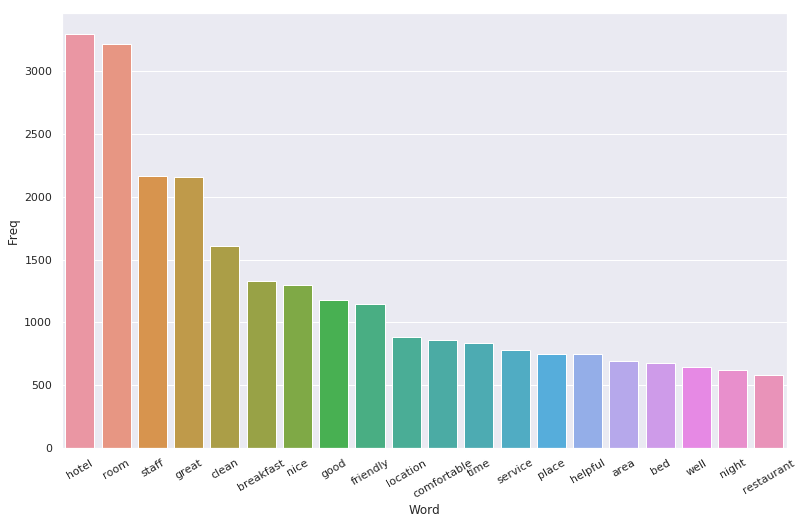

In [16]:
%matplotlib inline

#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key=lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns = ["Word", "Freq"]

#Barplot of most freq words
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
tick_labels = g.set_xticklabels(g.get_xticklabels(), rotation=30)

Above, I can see that the words "hotel" and "room" appear most frequently in 5 star reviews. Although the word "hotel" isn't that informative, the word "room" may indicate that the quality of the room was important for reviewers, which makes sense. In looking at some of the most frequently occurring adjectives, the word "clean" stands out as being related to the room. It's also telling that about half of these reviewers mentioned the staff, along with adjectives such as friendly, service, and helpful.

Next, I'll see if I can get more context by looking at bi-grams instead of words.

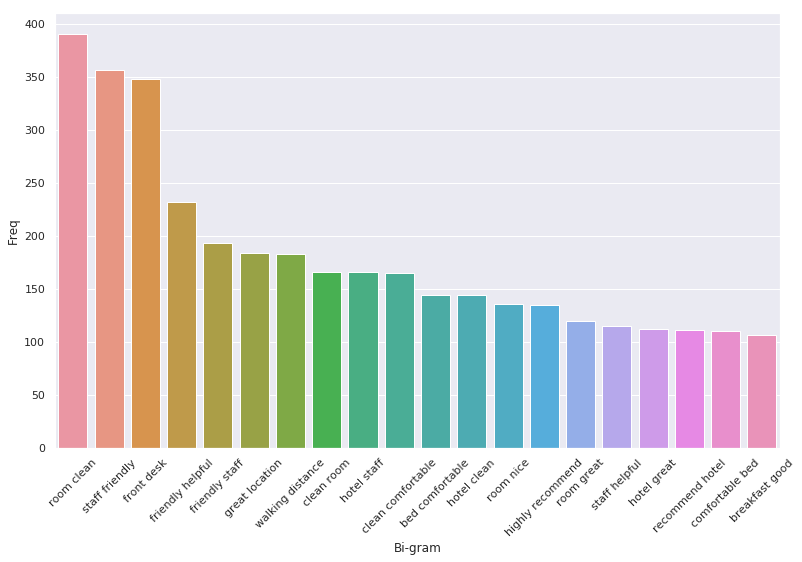

In [17]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]

#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
tick_labels = h.set_xticklabels(h.get_xticklabels(), rotation=45)

Above, I can see that my initial conjectures have merit, since "room clean", "staff friendly", and "front desk" make up the most frequently occuring bi-grams, along with other phrases with similar meanings such as "friendly staff" and "friendly helpful". 

# Conclusion

From the initial analysis above, I can tentatively conclude that cleanliness and customer service are very important for customer satisfaction in the hotel space. However, I can also improve the analysis by doing things like combining similar bi-grams, such as "staff friendly" and "staff helpful", and analyzing the reviews of lowly rated hotels. 